# To reproduce a run and investigate seasonal transition signature

In [1]:
# Import libraries
import os
import sys
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

sys.path.append("../libs/cfe_py")
from bmi_cfe import BMI_CFE

sys.path.append("../libs/SMSig")
from sig_seasontrans import SMSig

# Specify current directory create output directory if it does not exist
os.getcwd()

'g:\\Shared drives\\Ryoko and Hilary\\SMSigxModel\\analysis\\5_post_analysis'

# Configuration

In [2]:
site = "Mahurangi"
case = rf"{site}-2023-11-23"


In [3]:
data_directory = rf"..\data\{site}"
config_temp_path = os.path.join(data_directory, "temporary_parameter_files_for_GLUE", "config_cfe_0.json")
prior_params_path = rf"..\3_GLUE_prerun\results\{case}\prior_parameters.csv"
evaluation_metrics_path = rf"..\3_GLUE_prerun\results\{case}\evaluation_metrics.csv"
out_path = rf".\results\{case}"
if not os.path.exists(out_path):
    os.makedirs(out_path)

# Load parameters for a run

In [4]:
eval_metrics = pd.read_csv(evaluation_metrics_path)
# eval_metrics[(eval_metrics['KGE on Soil']>0.71) & (eval_metrics['SeasonTrans of Soil dry2wet_end']>50)]
# 93, 32, 71
eval_metrics[(eval_metrics['KGE on Soil']<0.5)&(eval_metrics['SeasonTrans of Soil dry2wet_end']<30)]
# run_id=190
# eval_metrics[(eval_metrics['KGE on Soil']>0.7) & (eval_metrics['SeasonTrans of Soil dry2wet_end']>50)]
# run_id=113, 9817

,run_id,NSE on Flow,NSE on Soil,KGE on Flow,KGE on Soil,SeasonTrans of Soil dry2wet_start,SeasonTrans of Soil dry2wet_end,SeasonTrans of Soil wet2dry_start,SeasonTrans of Soil wet2dry_end
23,23,0.881600,-10.303334,0.903028,0.408522,0.735526,26.303031,0.000104,0.000104
70,70,0.890796,-12.900283,0.938390,0.463870,0.136355,24.659863,0.000078,0.000078
93,93,0.875487,-6.214463,0.826496,0.421521,33.116555,3.283983,0.000488,0.000488
107,107,0.882199,-6.289359,0.832989,0.408217,33.293219,2.251331,0.002091,0.002091
179,179,0.875819,-2.679197,0.823116,0.449238,33.010109,2.139572,0.002244,0.002244
...,...,...,...,...,...,...,...,...,...
9832,9833,0.887460,-4.658289,0.839645,0.434675,33.095883,2.557260,0.000335,0.000335
9860,9861,0.874302,-6.893640,0.830703,0.408494,33.299436,3.657459,28.914408,28.914408
9911,9912,0.879458,-12.472199,0.839275,0.400945,32.985943,5.207987,0.000218,0.000218
9983,9984,0.870963,-10.858434,0.830472,0.461629,32.249582,6.947526,0.000155,0.000155


In [5]:
config_all_runs = pd.read_csv(prior_params_path)
config_all_runs.head()

,run_id,bb,satdk,slop,smcmax,wltsmc,max_gw_storage
0,0,10.635511,0.009909,0.970716,0.531666,0.238202,0.145304
1,1,4.969947,0.010761,0.241130,0.451027,0.237359,0.159545
2,2,9.448468,0.011238,0.153770,0.388745,0.269334,0.120130
3,3,9.261795,0.000229,0.586524,0.618626,0.300059,0.167953
4,4,9.140297,0.001092,0.404507,0.504158,0.347737,0.162977


In [6]:

run_id = 71
config_target_runs = config_all_runs[config_all_runs["run_id"]==run_id]
print(config_target_runs)

    run_id         bb     satdk      slop    smcmax    wltsmc  max_gw_storage
71      71  10.491084  0.007971  0.811784  0.612279  0.212717         0.16941


In [7]:
with open(config_temp_path, 'r') as outfile:
    config_temp = json.load(outfile)

In [8]:
for key, value in config_target_runs.items():
    if key == "run_id":
        None
    elif key in ['bb', 'satdk', 'slop', 'satpsi', 'smcmax', 'wltsmc', 'D']:
        config_temp["soil_params"][key] = value.values[0]
    else:
        config_temp[key] = value.values[0]
config_temp

{'forcing_file': 'G:/Shared drives/Ryoko and Hilary/SMSigxModel/analysis/data/Mahurangi/forcing_daily_1998_2001.csv',
 'catchment_area_km2': 46.65,
 'soil_params': {'bb': 10.491084070524147,
  'satdk': 0.0079714618246243,
  'slop': 0.8117835033701587,
  'smcmax': 0.6122788392365535,
  'wltsmc': 0.2127172457758437,
  'satpsi': 0.263,
  'D': 1},
 'max_gw_storage': 0.169409741887046,
 'Cgw': 0.0018,
 'expon': 4.47743251390116,
 'K_lf': 0.892110561724,
 'K_nash': 0.269168149445,
 'num_nash_storage': 2,
 'giuh_ordinates': [0.5, 0.5],
 'trigger_z_fact': 0.424510757139,
 'alpha_fc': 0.33,
 'refkdt': 3,
 'time_step_size': 86400,
 'stand_alone': 1,
 'unit_test': 1,
 'compare_results_file': 'G:/Shared drives/Ryoko and Hilary/SMSigxModel/analysis/data/Mahurangi/test_daily_1998_2001_sm_basinavg.csv'}

In [9]:
temporary_config_path = "temporary_config_reproducing_run"
if not os.path.exists(temporary_config_path):
    os.makedirs(temporary_config_path)

In [10]:
temporary_config_file = os.path.join(temporary_config_path, f"config_cfe_{run_id}.json")
with open(temporary_config_file, 'w') as out_file:
    json.dump(config_temp, out_file)

# Run CFE

GW & SM converged <1% after warm-up iteration 1; diff_gw: 0.0000000; diff_sm: 0.0000000


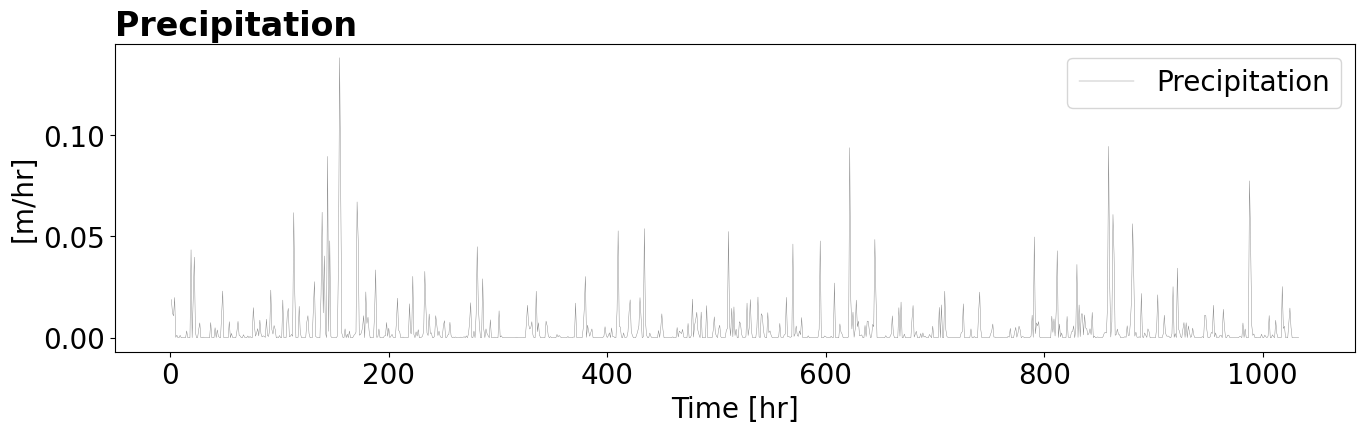

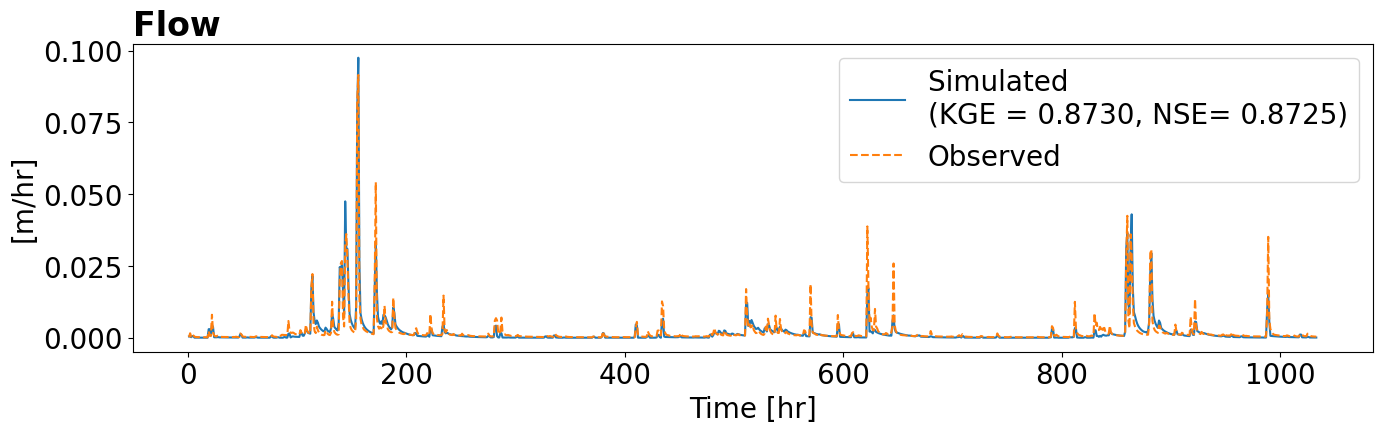

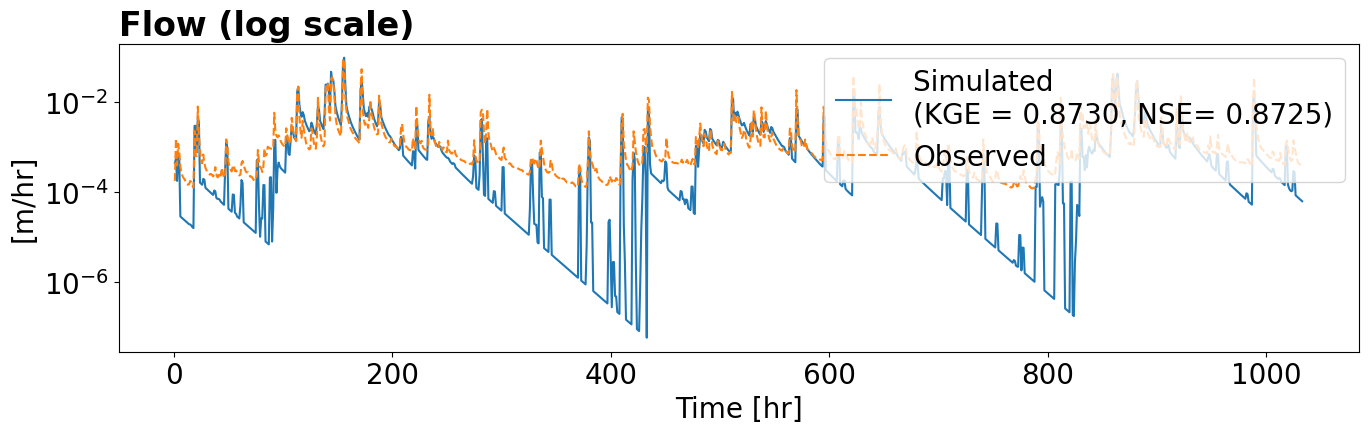

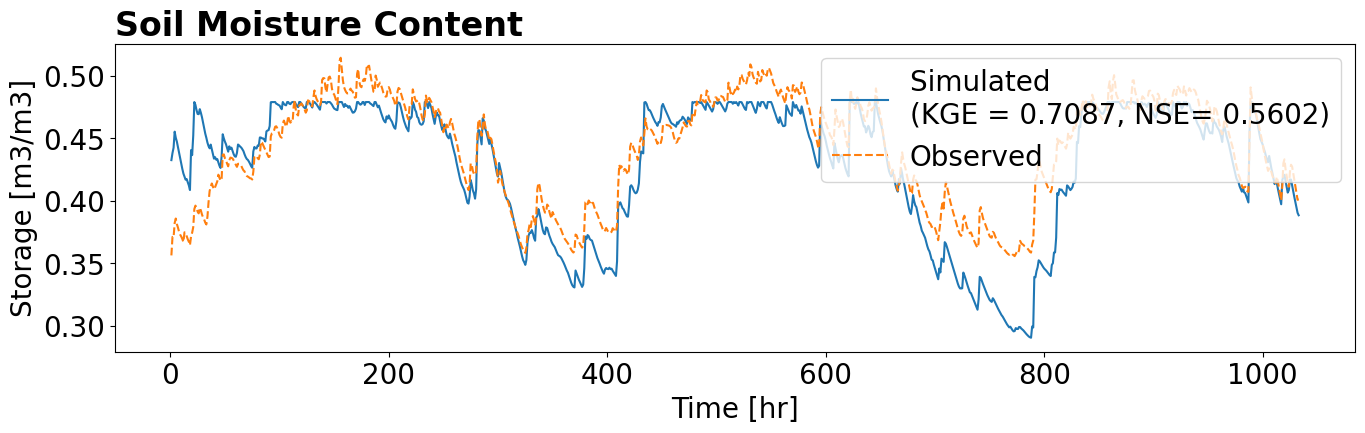

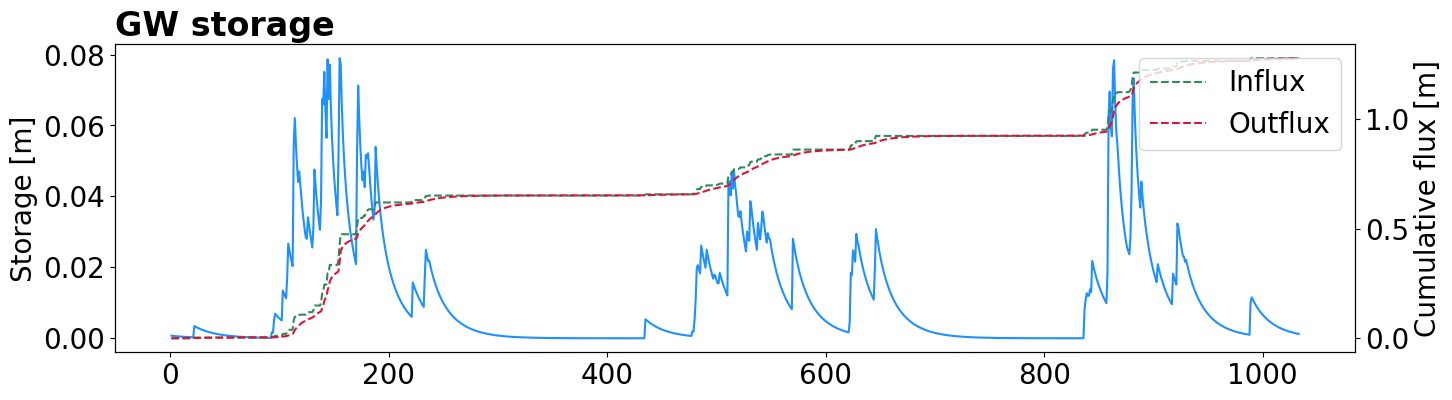

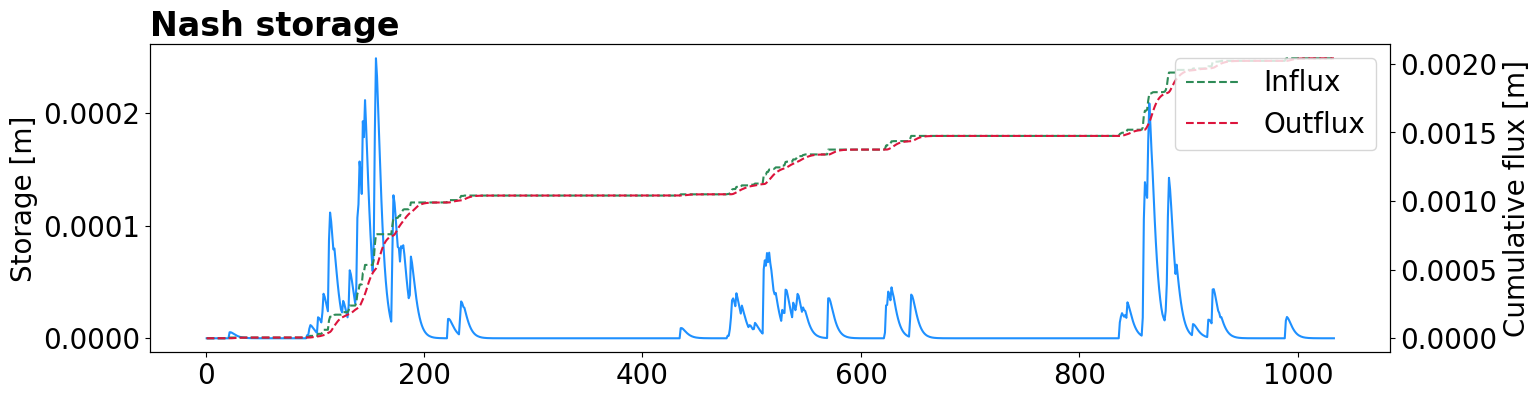

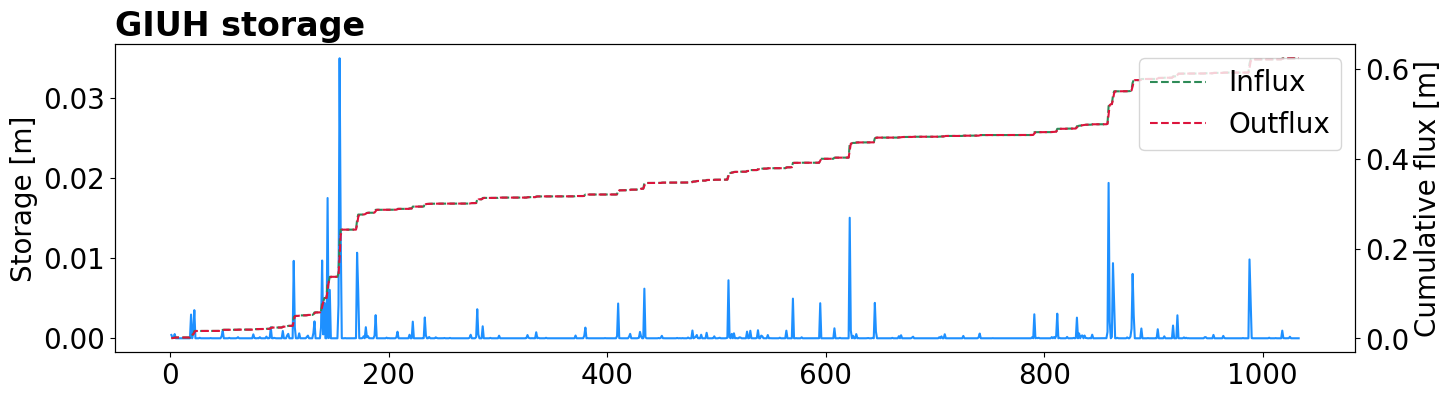

(      Soil Moisture Content
 0                  0.352933
 1                  0.356116
 2                  0.370902
 3                  0.370510
 4                  0.382052
 ...                     ...
 1290               0.471891
 1291               0.459832
 1292               0.465779
 1293               0.467198
 1294               0.457467
 
 [1295 rows x 1 columns],
       Soil Moisture Content
 0                  0.420157
 1                  0.432333
 2                  0.437967
 3                  0.442247
 4                  0.455094
 ...                     ...
 1290               0.478795
 1291               0.478063
 1292               0.478804
 1293               0.478237
 1294               0.476662
 
 [1295 rows x 1 columns])

In [11]:
# Run the CFE based on the config file
cfe_instance = BMI_CFE(temporary_config_file)
cfe_instance.initialize()
sim0 = cfe_instance.run_unit_test(plot=True,
    print_fluxes=True,
    plot_lims=list(range(1, 1034)),
    warm_up=True,
    warmup_offset=300,
    warmup_iteration=10
    )
obs0 = cfe_instance.load_unit_test_data()

# Get the results
var_name = 'Soil Moisture Content'
sim = sim0[["Time", var_name]].copy()
sim["Time"] = pd.to_datetime(sim["Time"], format="%Y-%m-%d")  # Works specifically for CFE

# Get the comparison data
obs = obs0[["Time", var_name]].copy()
obs["Time"] = pd.to_datetime(obs["Time"], format="%Y-%m-%d") 
# if study_site == "Mahurangi":
#     obs["Time"] = pd.to_datetime(obs["Time"], format="%m/%d/%Y %H:%M")  # Works specifically for Mahurangi data
# elif study_site == "LittleWashita":
#     obs["Time"] = pd.to_datetime(obs["Time"], format="%Y-%m-%d %H:%M:%S")  # works for Little ashita
# # obs["Time"] = pd.to_datetime(obs["Time"], format="%d-%m-%Y %H:%M:%S")

# Merge observed and simulated timeseries
df = pd.merge_asof(sim, obs, on="Time")

sim_synced = pd.DataFrame()
obs_synced = pd.DataFrame()
sim_synced[var_name] = df[var_name + "_x"].copy()
obs_synced[var_name] = df[var_name + "_y"].copy()

obs_synced, sim_synced

# Run seasonal signature

In [12]:
# Evaluate using seasonal soil moisture signature
sig_obs = SMSig(
    ts_time=df["Time"].to_numpy(),
    ts_value=obs_synced[var_name].to_numpy(),
    plot_results=False,
    plot_label="obs"
)

_t_valley_manual_input = pd.read_csv(
    os.path.join(data_directory, "seasonal_cycel_valleys.csv"), header=None
)
t_valley_manual_input = pd.to_datetime(_t_valley_manual_input[0])
season_trans_obs, start_dates_obs, end_dates_obs = sig_obs.calc_seasontrans(t_valley=t_valley_manual_input)

sig_sim = SMSig(
    ts_time=df["Time"].to_numpy(),
    ts_value=sim_synced[var_name].to_numpy(),
    plot_results=False,
    plot_label="sim"
)
season_trans_sim, start_dates_sim, end_dates_sim = sig_sim.calc_seasontrans(t_valley=t_valley_manual_input)

# Get the deviations in seasonal transition dates between simulated and observed timeseries
diff = season_trans_sim - season_trans_obs
metric_value = abs(np.nanmean(diff, axis=0))
print(diff)
print(metric_value)



[[ 6.84643054e+01 -2.72827966e+01  3.03663313e-04  3.03663313e-04]
 [ 2.57535415e+01 -3.31204858e+01  1.47149805e-03  1.47149805e-03]
 [ 1.10851664e+01  7.76668936e+00 -2.66960822e-04 -2.66960822e-04]
 [            nan             nan             nan             nan]
 [            nan             nan             nan             nan]
 [            nan             nan             nan             nan]]
[3.51010044e+01 1.75455310e+01 5.02733514e-04 5.02733514e-04]


# Load evaluation metrics

In [13]:
result_run = pd.read_csv(evaluation_metrics_path)
KGESM_for_the_run = result_run['KGE on Soil'][result_run["run_id"]==run_id].values[0]
print(KGESM_for_the_run)
result_run.head()

0.7122145918219995


,run_id,NSE on Flow,NSE on Soil,KGE on Flow,KGE on Soil,SeasonTrans of Soil dry2wet_start,SeasonTrans of Soil dry2wet_end,SeasonTrans of Soil wet2dry_start,SeasonTrans of Soil wet2dry_end
0,0,0.890585,-1.432626,0.924050,0.833892,9.054275,18.016273,0.000139,0.000139
1,1,0.880329,-19.273908,0.821450,0.093345,11.274072,38.151084,6.992221,48.848866
2,2,0.882486,-13.661172,0.765942,0.090475,13.715630,38.743163,6.757246,49.158875
3,3,0.867250,0.787172,0.884827,0.882432,7.280388,20.264794,0.000333,0.000333
4,4,0.886080,-2.640039,0.827121,0.188570,10.616118,38.074427,7.184139,49.265829


# Plot the results

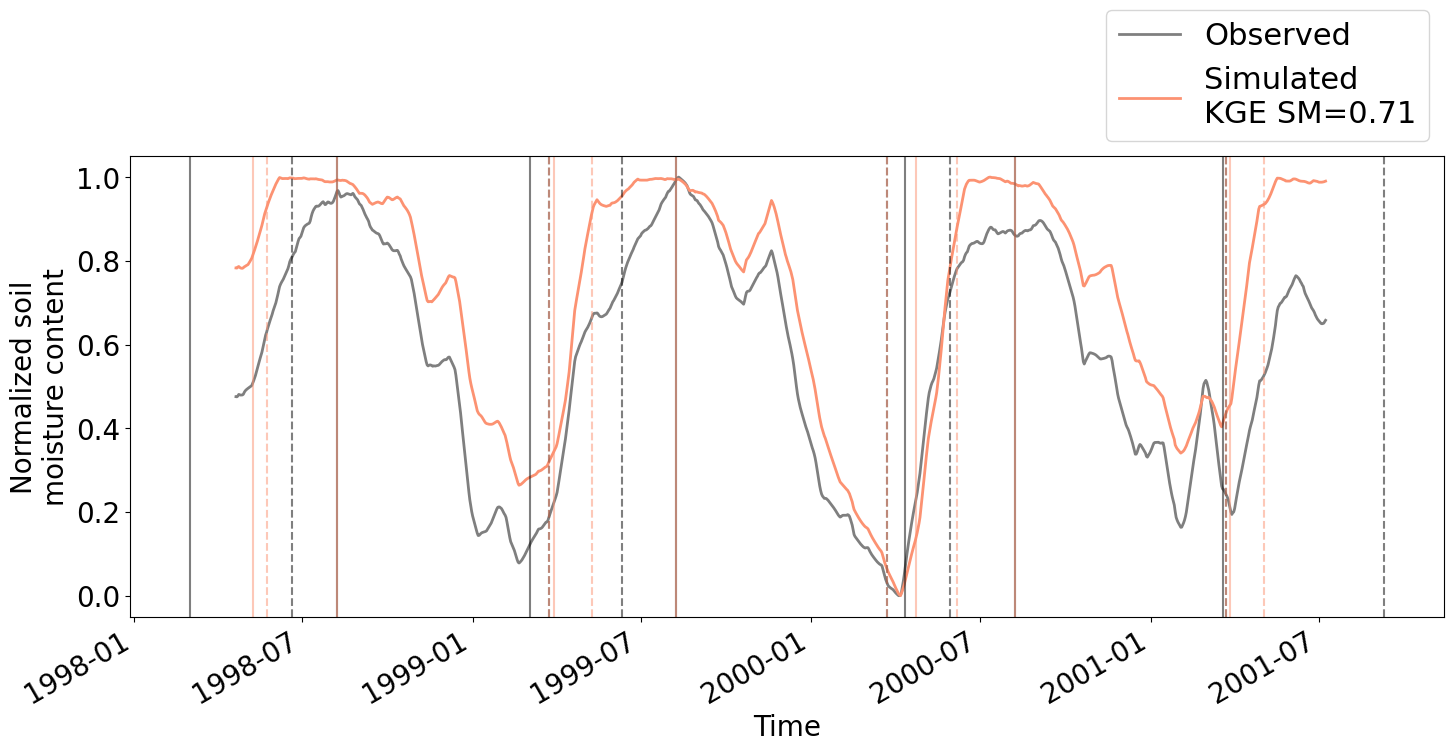

In [14]:
# Relative values of SM 
# Plot out the results
df_obs = obs_synced
df_sim = sim_synced
obs_label = 'Observed'
sim_label = f'Simulated\nKGE SM={KGESM_for_the_run:.2f}'
obs_color = 'k'
sim_color = '#fc9272'
y_label = 'Volumetric Soil Moisture Content [m^3/m^3]'
title = 'Soil moisture and seasonal transition signatures'
fn = 'timeseries.pdf'

f2 = plt.figure(figsize=(15, 8))
ax3 = f2.add_subplot()
plt.rc('font', size=22)
x_obs = sig_obs.tt.index
y_obs = (sig_obs.tt.values-min(sig_obs.tt.values))/(max(sig_obs.tt.values)-min(sig_obs.tt.values))
x_sim = sig_sim.tt.index
y_sim = (sig_sim.tt.values-min(sig_sim.tt.values))/(max(sig_sim.tt.values)-min(sig_sim.tt.values))
xlim_start = 60
xlim_end = len(x_obs)-60
ax3.plot(x_obs[xlim_start:xlim_end], y_obs[xlim_start:xlim_end], alpha=0.5, label=obs_label, color=obs_color, linewidth=2)
ax3.plot(x_sim[xlim_start:xlim_end], y_sim[xlim_start:xlim_end], alpha=1, label=sim_label, color=sim_color, linewidth=2)
for i in range(len(start_dates_obs)):
    ax3.axvline(x=start_dates_obs[i], color=obs_color, label=None, alpha=0.5, linestyle='-')
for i in range(len(end_dates_obs)):
    ax3.axvline(x=end_dates_obs[i], color=obs_color, label=None, alpha=0.5, linestyle='--')
for i in range(len(start_dates_sim)):
    ax3.axvline(x=start_dates_sim[i], color=sim_color, label=None, alpha=0.5, linestyle='-')
for i in range(len(end_dates_sim)):
    ax3.axvline(x=end_dates_sim[i], color=sim_color, label=None, alpha=0.5, linestyle='--')
ax3.set_xlabel('Time')
from datetime import datetime
ax3.set_ylabel('Normalized soil\nmoisture content')
# ax3.set_title(title)
ax3.legend(loc='lower right', bbox_to_anchor=(1,1))
plt.tight_layout()
f2.autofmt_xdate()
f2.savefig(os.path.join(out_path, fn), dpi=600, bbox_inches='tight')

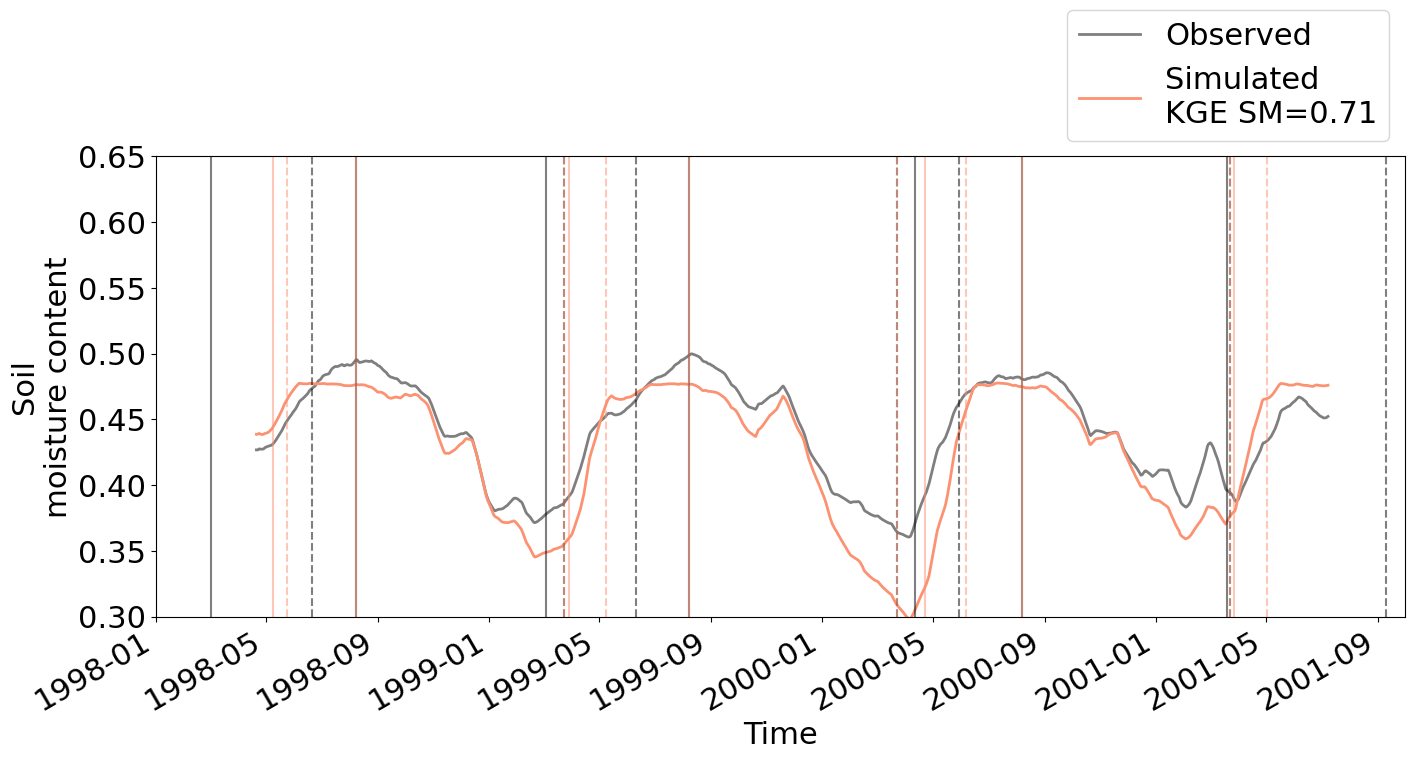

In [17]:
# Relative values of SM 
# Plot out the results
df_obs = obs_synced
df_sim = sim_synced
obs_label = 'Observed'
sim_label = f'Simulated\nKGE SM={KGESM_for_the_run:.2f}'
obs_color = 'k'
sim_color = '#fc9272'
y_label = 'Volumetric Soil Moisture Content [m^3/m^3]'
title = 'Soil moisture and seasonal transition signatures'
fn = 'timeseries.pdf'

f2 = plt.figure(figsize=(15, 8))
ax3 = f2.add_subplot()
plt.rc('font', size=22)
x_obs = sig_obs.tt.index
y_obs = sig_obs.tt.values
x_sim = sig_sim.tt.index
y_sim = sig_sim.tt.values
xlim_start = 60
xlim_end = len(x_obs)-60
ax3.plot(x_obs[xlim_start:xlim_end], y_obs[xlim_start:xlim_end], alpha=0.5, label=obs_label, color=obs_color, linewidth=2)
ax3.plot(x_sim[xlim_start:xlim_end], y_sim[xlim_start:xlim_end], alpha=1, label=sim_label, color=sim_color, linewidth=2)
for i in range(len(start_dates_obs)):
    ax3.axvline(x=start_dates_obs[i], color=obs_color, label=None, alpha=0.5, linestyle='-')
for i in range(len(end_dates_obs)):
    ax3.axvline(x=end_dates_obs[i], color=obs_color, label=None, alpha=0.5, linestyle='--')
for i in range(len(start_dates_sim)):
    ax3.axvline(x=start_dates_sim[i], color=sim_color, label=None, alpha=0.5, linestyle='-')
for i in range(len(end_dates_sim)):
    ax3.axvline(x=end_dates_sim[i], color=sim_color, label=None, alpha=0.5, linestyle='--')
ax3.set_xlabel('Time')
from datetime import datetime
ax3.set_ylabel('Soil\nmoisture content')
ax3.set_ylim([0.30, 0.65])
ax3.set_xlim(datetime(1998, 1,1), datetime(2001, 9, 30))
ax3.legend(loc='lower right', bbox_to_anchor=(1,1))
plt.tight_layout()
f2.autofmt_xdate()
f2.savefig(os.path.join(out_path, fn), dpi=600, bbox_inches='tight')



sig_sim.tt.to_csv(os.path.join(out_path, 'simulated.csv'))
sig_obs.tt.to_csv(os.path.join(out_path, 'observed.csv'))